In [2]:
import numpy as np
import scipy.stats as si
import scipy.stats.mstats
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KernelDensity

from torch.quasirandom import SobolEngine

from scipy.stats.distributions import norm
from scipy.optimize import fmin_bfgs
from scipy.stats import gaussian_kde

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [3]:
def BlackScholesExactSimulation(S, dts, r, sigma, numPath):
    out = []
    W = []
    
    if isinstance(S, np.ndarray) and len(S) == numPath:
        currentPath = S
    else:
        currentPath = np.ones(numPath) * S
        
    out.append(np.array(currentPath))

    for i in range(len(dts)-1):
        wPath = np.random.normal(0,1, int(numPath / 2))
        wPath = np.array([wPath, -wPath]).flatten()
        avgVar = np.var(wPath)
        wPath /= np.sqrt(avgVar)
        wPath -= np.average(wPath)
        W.append(np.array(wPath))
        dt = dts[i+1]-dts[i]
        currentPath *= np.exp((r - (sigma * sigma * 0.5))*dt + sigma * math.sqrt(dt) * wPath)
        out.append(np.array(currentPath))
    return (out, W)

def BlackScholesExactSimulationSobol(S, dts, r, sigma, numPath, scramble=True):
    out = []
    W = []
    
    if isinstance(S, np.ndarray) and len(S) == numPath:
        currentPath = S
    else:
        currentPath = np.ones(numPath) * S
        
    out.append(np.array(currentPath))

    engine = SobolEngine(len(dts)-1, scramble=scramble, seed=None)
    totalW = si.norm.ppf(np.array(engine.draw(numPath))*(1-2e-7)+1e-7)

    for i in range(len(dts)-1):
        wPath = totalW[:,i]
        wPath -= np.average(wPath)
        wPath /= np.sqrt(np.var(wPath))
        W.append(np.array(wPath))
        dt = dts[i+1]-dts[i]
        currentPath *= np.exp((r - (sigma * sigma * 0.5))*dt + sigma * math.sqrt(dt) * wPath)
        out.append(np.array(currentPath))
    return (out, W)


def BlackScholesStdDev(S, T, r, sigma):
    return np.sqrt(S * S * np.exp(2 * T * (r - sigma * sigma * 0.5)) * (np.exp(sigma * sigma * T) - 1.0))

def PriceEuroVanilla(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

def PriceEuroVanillaDelta(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = si.norm.cdf(d1, 0.0, 1.0)
    if option == 'put':
        result =  - si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

def PriceEuroVanillaGamma(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    result = si.norm.pdf(d1, 0.0, 1.0)/(S*sigma*np.sqrt(T))

    return result

def PriceEuroVanillaVega(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    result = S * si.norm.pdf(d1, 0.0, 1.0) * math.sqrt(T)
        
    return result


def PriceBarrierOptions(S, K, r, sigma, T, H):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    nd1 = norm.cdf(d1, 0.0, 1.0)
    nd2 = norm.cdf(d2, 0.0, 1.0)
    nd1minus = norm.cdf(-d1, 0.0, 1.0)
    nd2minus = norm.cdf(-d2, 0.0, 1.0)

    l = (r + (sigma * sigma *0.5)) / (sigma * sigma)
    y = np.log((H*H)/(S*K)) / (sigma * np.sqrt(T)) + l * sigma * np.sqrt(T)
    x1 = np.log(S/H)/(sigma * np.sqrt(T))+l*sigma * np.sqrt(T)
    y1 = np.log(H/S)/(sigma * np.sqrt(T))+l*sigma * np.sqrt(T)

    c = S * nd1 - K * np.exp(-r*T) * nd2
    p = K * np.exp(-r*T) * nd2minus  - S * nd1minus
    cdi = S * (H/S)**(2*l) * norm.cdf(y) - K * np.exp(-r*T) * (H/S)**(2*l-2.0) * norm.cdf(y-sigma*np.sqrt(T))
    pdi = - S * norm.cdf(-x1) + K * np.exp(-r*T) * norm.cdf(-x1+sigma*np.sqrt(T)) + S*(H/S)**(2*l)*(norm.cdf(y)-norm.cdf(y1))-K*np.exp(-r*T)*(H/S)**(2*l-2.0)*(norm.cdf(y-sigma*np.sqrt(T))-norm.cdf(y1-sigma*np.sqrt(T))) 
    
    cdo = c - cdi
    pdo = p - pdi

    result=np.maximum([c,p,cdi,cdo,pdi,pdo], 0.0)
    #result = {
        #'c' : c,
        #'p' : p,
        #'cdi' : cdi,
        #'cdo' : cdo,
        #'pdi' : pdi,
        #'pdo' : pdo
    #}

    return result 


def TerminalDigitalPayoff(putStrikes, callStrikes, ST):
    payoffs = []
    labels = []
    
    fwd = np.average(ST)
    #labels.append('ATM Fwd')
    #payoffs.append(np.array(ST) - fwd)
    
    
    for strike in putStrikes:
        payoffs.append(1.0 * (strike - ST > 0))
        labels.append(str(strike) + ' Digi Put')
    for strike in callStrikes:
        payoffs.append(1.0 * (ST - strike > 0))
        labels.append(str(strike) + ' Digi Call')
    return payoffs, labels

def TerminalVanillaPayoff(putStrikes, callStrikes, ST):
    payoffs = []
    labels = []
    
    fwd = np.average(ST)
    #labels.append('ATM Fwd')
    #payoffs.append(np.array(ST) - fwd)
    
    if not putStrikes is None:
        for strike in putStrikes:
            payoffs.append(np.maximum(strike - ST, 0))
            labels.append(str(strike) + ' Put')
            
    if not callStrikes is None:
        for strike in callStrikes:
            payoffs.append(np.maximum(ST - strike, 0))
            labels.append(str(strike) + ' Call')
    return payoffs, labels

def PayoffUtility(port, targetPayoff, matchingPayoffs, risk_aversion = gamma):
    l = risk_aversion
    numPath = len(targetPayoff)
    portTiled = np.tile(port, numPath).reshape(numPath, -1).T
    x = np.sum(portTiled * matchingPayoffs, 0) - targetPayoff
    mean = np.average(x)
    return np.log(np.mean(np.exp(-l * x))) / l

def LogContractPayoff(S, eps=0.0):
    diff = 0.0
    numPath = len(S[0])
    for i in np.arange(len(S)-1):
        noise = 1.0 + np.random.normal(0,eps,numPath)
        diff += ((S[i+1]*noise-S[i])/S[i])
    return [diff, -np.log(S[-1]/S[0])], ['diff', 'LogForward']

def VarswapPayoff(K, S, A):
    variance = 0.0
    for i in np.arange(len(S)-1):
        variance += np.log(S[i+1]/S[i]) ** 2
    variance *= A / (len(S) - 1)
    return variance - K

NameError: name 'gamma' is not defined

In [ ]:
S0 = 100.0
numPath = 10000
r = 0.0
T = 1.0
sigmaP = 0.2
sigmaQ = 0.4

dts = np.arange(0.0, T, 0.1)
T = dts[-1]

putStrikes = None
callStrikes = [110.0, 120.0]

(S_P, W_P) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaP, numPath)
(S_Q, W_Q) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaQ, numPath)

S_PT = S_P[-1]
S_QT = S_Q[-1]

payoffs_P, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_PT)
payoffs_Q, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_QT)

prices_P = np.mean(payoffs_P, 1) * np.exp(-r*T)
prices_Q = np.mean(payoffs_Q, 1) * np.exp(-r*T)

gamma = 0.1
K1 = 120.0
K2 = 110.0
bP = np.maximum(S_PT - K2, 0.0) - np.maximum(S_PT - K1, 0.0) 
bQ = np.maximum(S_QT - K2, 0.0) - np.maximum(S_QT - K1, 0.0) 

prices_tiled = np.tile(prices_Q, numPath).reshape(numPath, -1).T
n_assets = prices_tiled.shape[0]

deltas = np.array(payoffs_P) - prices_tiled

def W0(lambdas):
    n_assets = deltas.shape[0]
    n_paths = deltas.shape[1]
    return np.log(np.sum(np.exp(np.matmul(lambdas, deltas) + bP*gamma) / n_assets))

lambdas = fmin_bfgs(W0, np.zeros(n_assets))

Z0 = np.sum(np.exp(np.matmul(lambdas, deltas)) / n_assets)
m = (np.exp(np.matmul(lambdas, deltas)) / n_assets) / Z0

n = np.ones(numPath) * (1/numPath)
l = np.mean(np.log(n/m))
np.sum(bP * m), np.sum(bP * n), np.sum(bQ * n), -lambdas / gamma

In [1737]:
n = np.ones(numPath) * (1/numPath)
l = np.mean(np.log(n/m))
np.sum(bP * m), np.sum(bP * n), np.sum(bQ * n), -lambdas / gamma

(1.395245588455901,
 2.0499642745430813,
 2.886295795283853,
 array([ 1.66836285, -2.31016603]))

In [1736]:
port_v = fmin_bfgs(PayoffUtility, np.zeros(len(payoffs_P)), args=(bP, deltas, gamma))
pd.DataFrame(port_v)

Optimization terminated successfully.
         Current function value: 0.372735
         Iterations: 9
         Function evaluations: 33
         Gradient evaluations: 11


,0
0,1.668363
1,-2.310166


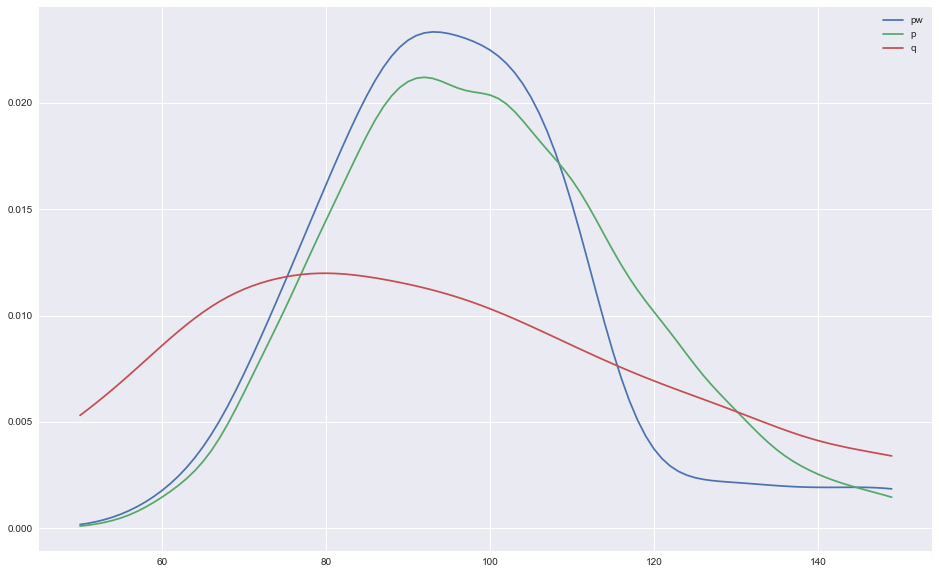

In [1738]:
bins = np.arange(50.0, 150.0, 1.0)

kernel_pw = gaussian_kde(S_PT, weights=m)
kernel_p = gaussian_kde(S_PT)
kernel_q = gaussian_kde(S_QT)

scores_pw = kernel_pw(bins)
scores_p = kernel_p(bins)
scores_q = kernel_q(bins)

plt.figure(figsize=[16,10])
plt.plot(bins, scores_pw, label='pw')
plt.plot(bins, scores_p, label='p')
plt.plot(bins, scores_q, label='q')

plt.legend()

0.0 [ 0.01207088 -0.03996813]
0.01 [ 2.20708764 -4.99681135] 0.15941876078942085
0.05 [ 1.24141732 -1.79936204] 0.7165519618991907
0.1 [ 1.12070871 -1.39968105] 1.2427166214869778
0.5 [ 1.02414184 -1.0799365 ] 2.322560812254606
1.0 [ 1.01207087 -1.03996811] 2.387086347263412
5.0 [ 1.00241417 -1.00799362] 2.4057620818541183

Indifference Prices
[2.40664667 2.40664667 2.40664667 2.40664667 2.40664667 2.40664667]

Risk Neutral Price
2.406646330735558


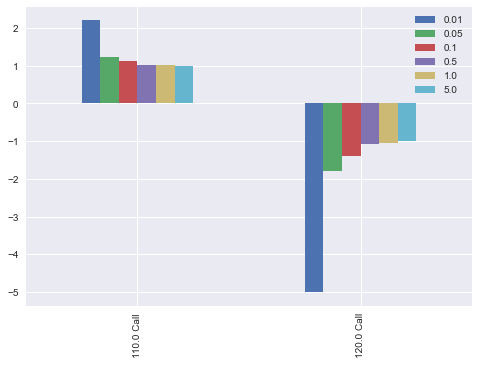

In [2995]:
S0 = 100.0
numPath = 10000
r = 0.0
T = 1.0
sigmaP = 0.2
sigmaQ = 0.25

dts = np.arange(0.0, T, 0.1)
T = dts[-1]

putStrikes = None
callStrikes = [110.0, 120.0]

(S_P, W_P) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaP, numPath, scramble=False)
(S_Q, W_Q) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaQ, numPath, scramble=False)

S_PT = S_P[-1]
S_QT = S_Q[-1]

payoffs_P, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_PT)
payoffs_Q, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_QT)

prices_P = np.mean(payoffs_P, 1) * np.exp(-r*T)
prices_Q = np.mean(payoffs_Q, 1) * np.exp(-r*T)

gammas = [0.00, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]

lambdaList = []
wbList = []
w_0 = 0

for gamma in gammas:
    K1 = 120.0
    K2 = 110.0
    bP = np.maximum(S_PT - K2, 0.0) - np.maximum(S_PT - K1, 0.0) 
    bQ = np.maximum(S_QT - K2, 0.0) - np.maximum(S_QT - K1, 0.0) 

    prices_tiled = np.tile(prices_Q, numPath).reshape(numPath, -1).T
    n_assets = prices_tiled.shape[0]

    deltas = np.array(payoffs_P) - prices_tiled

    def W0(lambdas):
        n_assets = deltas.shape[0]
        n_paths = deltas.shape[1]
        return np.log(np.sum(np.exp(np.matmul(lambdas, deltas) + bP*gamma) / n_assets))

    lambdas = fmin_bfgs(W0, np.zeros(n_assets), disp=0)
    wb = W0(lambdas)
    wbList.append(wb)
    lambdaList.append(lambdas)
    
    Z0 = np.sum(np.exp(np.matmul(lambdas, deltas)) / n_assets)
    m = (np.exp(np.matmul(lambdas, deltas)) / n_assets) / Z0
    n = np.ones(numPath) * (1/numPath)
    l = np.mean(np.log(n/m))
    if gamma == 0:
        m_0 = m
        w_0 = wb
        print(gamma, -lambdas)
    else:
        port_v
        print(gamma, -lambdas / gamma, np.sum(m_0 * bP) - np.sum(m * bP))
        
df = pd.DataFrame()
s0 = pd.Series(-np.array(lambdaList[1:])[:,0]/np.array(gammas)[1:], index=gammas[1:], name=vlabels[0])
s1 = pd.Series(-np.array(lambdaList[1:])[:,1]/np.array(gammas)[1:], index=gammas[1:], name=vlabels[1])
df = pd.DataFrame([s0,s1])
df.plot.bar()


print()
print('Indifference Prices')
print((wbList[1:] - w_0)/gammas[1:])
print()
print('Risk Neutral Price')
print(np.sum(m_0 * bP))


In [3008]:
np.sum(prices_Q * [0.01207088, -0.03996813])

-0.06270021304724953

In [3002]:
prices_Q 

array([5.69552124, 3.28887457])

In [2056]:
(wbList[1:] - w_0)/gammas[1:]

array([2.41368397, 2.41368397, 2.41368397, 2.41368397, 2.41368397,
       2.41368397])

In [1907]:
idx = 3
gammas[idx], -(lambdaList[idx] - lambdaList[0]) / gammas[idx], -lambdaList[idx] / gammas[idx], ports[idx]

(0.5,
 array([ 1.00000008, -1.00000025]),
 array([ 1.02414184, -1.0799365 ]),
 array([ 1.02414308, -1.07993794]))

Actual Price = 2.4136839734098596
0.0
-3.9180030219626403
1.1473481191147545
1.7805162468938232
2.287050441935686


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


2.350367162450004
2.401020602340691


<AxesSubplot:>

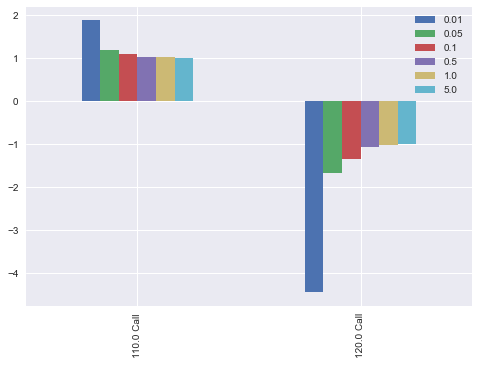

In [2882]:
def PayoffUtility(port, targetPayoff, matchingPayoffs, risk_aversion = gamma):
    l = risk_aversion
    numPath = len(targetPayoff)
    portTiled = np.tile(port, numPath).reshape(numPath, -1).T
    x = np.sum(portTiled * matchingPayoffs, 0) - targetPayoff
    mean = np.average(x)
    return np.log(np.mean(np.exp(-l * x))) / l

ports = []

S0 = 100.0
numPath = 100000
r = 0.0
T = 1.0
sigmaP = 0.2
sigmaQ = 0.25

dts = np.arange(0.0, T, 0.1)
T = dts[-1]

putStrikes = None
callStrikes = [110.0, 120.0]

(S_P, W_P) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaP, numPath, scramble=False)
(S_Q, W_Q) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaQ, numPath, scramble=False)

S_PT = S_P[-1]
S_QT = S_Q[-1]

payoffs_P, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_PT)
payoffs_Q, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_QT)

prices_P = np.mean(payoffs_P, 1) * np.exp(-r*T)
prices_Q = np.mean(payoffs_Q, 1) * np.exp(-r*T)

print('Actual Price = ' + str(prices_Q[0] - prices_Q[1]))

K1 = 120.0
K2 = 110.0
    
bP = np.maximum(S_PT - K2, 0.0) - np.maximum(S_PT - K1, 0.0) 
bQ = np.maximum(S_QT - K2, 0.0) - np.maximum(S_QT - K1, 0.0) 

gammas = [0.00, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]

prices_tiled = np.tile(prices_Q, numPath).reshape(numPath, -1).T
deltas = np.array(payoffs_P) - prices_tiled

for gamma in gammas:
    port_v = fmin_bfgs(PayoffUtility, np.zeros(len(payoffs_P)), args=(bP, deltas, gamma), disp=0)
    print(np.sum(port_v*prices_Q))
    ports.append(port_v)
    
df = pd.DataFrame()
s0 = pd.Series(np.array(ports[1:])[:,0], index=gammas[1:], name=vlabels[0])
s1 = pd.Series(np.array(ports[1:])[:,1], index=gammas[1:], name=vlabels[1])
df = pd.DataFrame([s0,s1])
df.plot.bar()




<AxesSubplot:>

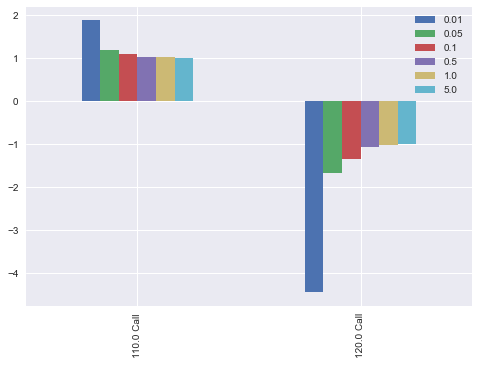

In [2368]:
df = pd.DataFrame()
s0 = pd.Series(np.array(ports[1:])[:,0], index=gammas[1:], name=vlabels[0])
s1 = pd.Series(np.array(ports[1:])[:,1], index=gammas[1:], name=vlabels[1])
df = pd.DataFrame([s0,s1])
df.plot.bar()

0.0 [-0.03123781  0.02857444  0.11979966 -0.14297846  0.02314767] 0.2230707366509613
0.05 [-0.6281889   0.57458026  3.03038021 -3.17123471  1.16868546] 12.32439998278322 7.40743708181178
0.1 [-0.31485532  0.28797506  1.80776566 -1.5027025   0.72726276] 10.35726565028226 7.446345700662526
0.5 [-6.42409346e-02  5.87402934e-02  8.84455874e-01  1.31933285e-01
 -7.48567471e-04] 9.082036186927658 7.470896154666185
1.0 [-0.03417575  0.03122299  0.87015027  0.21278174 -0.07482344] 8.984609080867644 7.472647686035394
3.0 [-0.01334801  0.01216943  0.94558787  0.09941533 -0.04233998] 8.927264552564978 7.473689077732646

Indifference Prices
[7.9254849  8.15219387 8.63159737 8.7441569  8.83266413]

Risk Neutral Price
7.503202854410649 7.668675420153785


<AxesSubplot:>

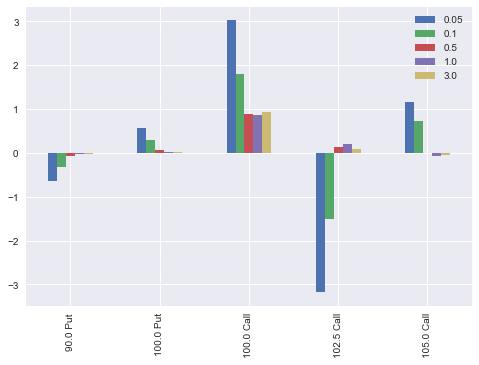

In [2993]:
S0 = 100.0
numPath = 100000
r = 0.02
T = 1.0
H = 90
K = 100
sigmaP = 0.2
sigmaQ = 0.2

dts = np.arange(0.0, T, 0.005)
T = dts[-1]

putStrikes = [90.0, 100.0]
callStrikes = [100.0, 102.5, 105.0]

(S_P, W_P) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaP, numPath)
(S_Q, W_Q) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaQ, numPath)

S_PT = S_P[-1]
S_QT = S_Q[-1]

payoffs_P, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_PT)
payoffs_Q, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_QT)

prices_P = np.mean(payoffs_P, 1) * np.exp(-r*T)
prices_Q = np.mean(payoffs_Q, 1) * np.exp(-r*T)

gammas = [0.00, 0.05, 0.1, 0.5, 1.0, 3.0]
bP = np.maximum(S_PT - K, 0.0) * (np.min(S_P,axis=0) > H)
bQ = np.maximum(S_QT - K, 0.0) * (np.min(S_Q,axis=0) > H)

lambdaList = []
wbList = []
portList = []

for gamma in gammas:
    prices_tiled = np.tile(prices_Q, numPath).reshape(numPath, -1).T
    n_assets = prices_tiled.shape[0]

    deltas = np.array(payoffs_P) - prices_tiled

    def W0(lambdas):
        n_assets = deltas.shape[0]
        n_paths = deltas.shape[1]
        return np.log(np.sum(np.exp(np.matmul(lambdas, deltas) + bP*gamma) / n_assets))

    lambdas = fmin_bfgs(W0, np.zeros(n_assets), disp=0)
    wb = W0(lambdas)
    wbList.append(wb)
    lambdaList.append(lambdas)
    
    Z0 = np.sum(np.exp(np.matmul(lambdas, deltas)) / n_assets)
    m = (np.exp(np.matmul(lambdas, deltas)) / n_assets) / Z0
    n = np.ones(numPath) * (1/numPath)
    l = np.mean(np.log(n/m))
    
    if gamma == 0:
        m_0 = m
        w_0 = wb
        
        port = -lambdas
        port_tiled = np.tile(port, numPath).reshape(numPath, -1).T
        portVal = np.sum(payoffs_Q * port_tiled,0)
        
        print(gamma, -lambdas, np.mean(portVal))
    else:
        port = (-lambdas / gamma)
        portList.append(port)
        
        port_tiled = np.tile(port, numPath).reshape(numPath, -1).T
        portVal = np.sum(payoffs_P * port_tiled,0)
        res = bP - portVal

        print(gamma, -lambdas / gamma, np.sum(port * prices_Q), np.sum(port * prices_Q) + np.mean(res))

print()
print('Indifference Prices')
print((wbList[1:] - w_0)/gammas[1:])
print()
print('Risk Neutral Price')
print(np.sum(m_0 * bP), np.mean(bQ))

df = pd.DataFrame()
sList = []

for idx in range(len(portList)):
    sList.append(pd.Series(np.array(portList)[:,idx].T, index=gammas[1:], name=vlabels[idx]))

df = pd.DataFrame(sList)
df.plot.bar()

In [2987]:
portVal * prices_Q

ValueError: operands could not be broadcast together with shapes (100000,) (5,) 

In [2984]:
portVal

array([ 0.06967011, 12.10058579,  0.10723445, ...,  0.11167293,
        0.06600646,  2.87133661])

0.0 [-0.03259527  0.02937008  0.13710018 -0.18090283  0.04413911]
0.05 12.406943975309458
0.1 10.409460361540734
0.5 9.108919668932609
1.0 9.008220090319805
3.0 8.947762446735876

Indifference Prices
[7.95389327 8.17587989 8.6502173  8.76219065 8.85019282]

Risk Neutral Price
7.694271697065709
7.543470774586992


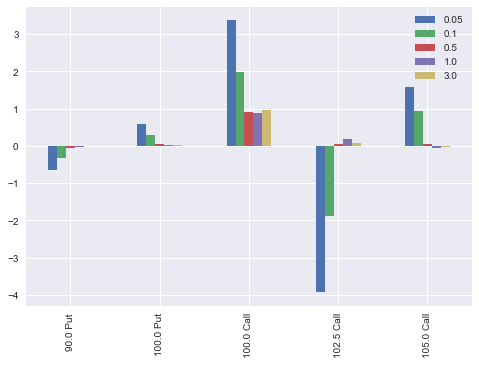

In [3010]:
S0 = 100.0
numPath = 100000
r = 0.02
T = 1.0
H = 90
K = 100
sigmaP = 0.2
sigmaQ = 0.2

dts = np.arange(0.0, T, 0.005)
T = dts[-1]

putStrikes = [90.0, 100.0]
callStrikes = [100.0, 102.5, 105.0]

(S_P, W_P) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaP, numPath)
(S_Q, W_Q) = BlackScholesExactSimulationSobol(S0, dts, r, sigmaQ, numPath)

S_PT = S_P[-1]
S_QT = S_Q[-1]

payoffs_P, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_PT)
payoffs_Q, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_QT)

prices_P = np.mean(payoffs_P, 1) * np.exp(-r*T)
prices_Q = np.mean(payoffs_Q, 1) * np.exp(-r*T)

gammas = [0.00, 0.05, 0.1, 0.5, 1.0, 3.0]
bP = np.maximum(S_PT - K, 0.0) * (np.min(S_P,axis=0) > H)
bQ = np.maximum(S_QT - K, 0.0) * (np.min(S_Q,axis=0) > H)

lambdaList = []
wbList = []
portList = []

for gamma in gammas:
    prices_tiled = np.tile(prices_Q, numPath).reshape(numPath, -1).T
    n_assets = prices_tiled.shape[0]

    deltas = np.array(payoffs_P) - prices_tiled

    def W0(lambdas):
        n_assets = deltas.shape[0]
        n_paths = deltas.shape[1]
        return np.log(np.sum(np.exp(np.matmul(lambdas, deltas) + bP*gamma) / n_assets))

    lambdas = fmin_bfgs(W0, np.zeros(n_assets), disp=0)
    wb = W0(lambdas)
    wbList.append(wb)
    lambdaList.append(lambdas)
    
    Z0 = np.sum(np.exp(np.matmul(lambdas, deltas)) / n_assets)
    m = (np.exp(np.matmul(lambdas, deltas)) / n_assets) / Z0
    n = np.ones(numPath) * (1/numPath)
    l = np.mean(np.log(n/m))
    
    if gamma == 0:
        m_0 = m
        w_0 = wb
        print(gamma, -lambdas)
    else:
        portList.append((-lambdas / gamma))
        print(gamma, np.dot((-lambdas / gamma), prices_Q))
        
df = pd.DataFrame()
sList = []

s0 = pd.Series(np.array(portList)[:,0], index=gammas[1:], name=vlabels[0])
s1 = pd.Series(np.array(portList)[:,1], index=gammas[1:], name=vlabels[1])
s2 = pd.Series(np.array(portList)[:,2], index=gammas[1:], name=vlabels[2])
s3 = pd.Series(np.array(portList)[:,3], index=gammas[1:], name=vlabels[3])
s4 = pd.Series(np.array(portList)[:,4], index=gammas[1:], name=vlabels[4])

df = pd.DataFrame([s0,s1,s2,s3, s4])
df.plot.bar()

print()
print('Indifference Prices')
print((wbList[1:] - w_0)/gammas[1:])
print()
print('Risk Neutral Price')
print(np.mean(bQ))
print(np.sum(m_0 * bP))


In [3011]:
np.sum(np.array(portList)[3,:] * prices_Q)

9.008220090319805

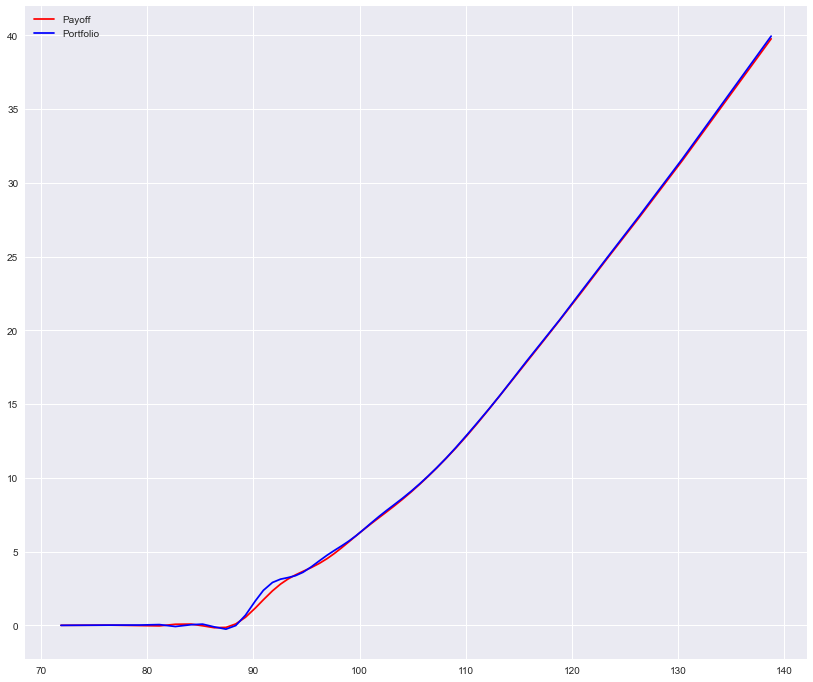

In [3029]:
import time

S0 = 100.0
numPath = 20000
K = 100.0
r = 0.02
H = 90.0
sigmaP = 0.2
sigmaQ = 0.25
dts = [0.0, 0.5, 1.0]
T = dts[len(dts)-1]
grid = 200
dt = T / grid

spval = []
mse = []
abserr = []
#np.random.seed(0)

spSim = np.linspace(0.0, T, num=grid)
spSim = np.sort(np.unique(np.hstack([spSim, dts])))

(SAll_P, WAll_P) = BlackScholesExactSimulationSobol(S0, spSim, r, sigmaP, numPath)
(SAll_Q, WAll_Q) = BlackScholesExactSimulationSobol(S0, spSim, r, sigmaQ, numPath)

S_P = np.vstack([SAll_P[0], SAll_P[spSim.tolist().index(dts[1])], SAll_P[-1]])
S_Q = np.vstack([SAll_Q[0], SAll_Q[spSim.tolist().index(dts[1])], SAll_Q[-1]])

S_PT = S_P[-1]
S_QT = S_Q[-1]

bP = np.maximum(S_PT - K, 0.0) * (np.min(S_P,axis=0) > H)
bQ = np.maximum(S_QT - K, 0.0) * (np.min(S_Q,axis=0) > H)

sp = np.linspace(1.0, 99.0, num=50)
sp = np.percentile(S_P[1],sp)

payoffs_P, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_PT)
payoffs_Q, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_QT)

port_tiled = np.tile(portList[3], numPath).reshape(numPath, -1).T
port = np.sum(payoffs_P * port_tiled,0)
res = bP - port

payoffs = []
values = []
payoffs.append(bP)
payoffs.append(port)
payoffs.append(res)

for p in payoffs:
    kout = []
    priceout = []
    varout = []
    covarout = []
    deltaout = []
    S2out = []
    derivout = []
    deriv2out = []
    
    #Silverman's rule of thumb
    payoff = p
    payoff_stdev = math.sqrt(np.var(S_PT))
    eps = 1.0 / (0.9 * payoff_stdev * numPath ** (-0.2))
    eps /= 1.0

    for start in sp:
        k = np.exp(-eps * (S[1] - start)**2)
        kout.append(np.sum(k) + 1e-7)

    kRatio = max(kout) / kout
    kRatio = np.minimum(10.0, max(kout) / kout)

    #kernel regression
    for idx, start in enumerate(sp):
        epsBS = eps
        epsBS /= kRatio[idx]
        k = np.exp(-epsBS * (S_P[1] - start)**2) + 1e-10

        #excl anything that already knocked out
        #k[np.min(SAll_P[0:np.argmin(spSim < dts[1])], axis=0) < H] = 0.0

        diff = (S_P[1] - start)
        kd = k * diff
        kd2 = kd *  diff
        wll = k * np.sum(kd2) - diff * k * np.sum(kd)
        wllsum = np.sum(wll) + 1e-10

        kout.append(np.sum(k))
        yprice = p

        #Have to discount by the future price
        S2Avg = np.sum(S_P[2] * wll) / wllsum
        S2Avg *= math.exp(-r*(dts[2] - dts[1]))
        S2out.append(S2Avg)

        fitprice = np.sum(yprice*wll) / wllsum
        if start < H:
            fitprice = 0.0
            payoffDeriv = 0.0

        priceout.append(fitprice)
        derivout.append(np.sum(payoffDeriv*wll) / wllsum)

        ycov = (payoff - fitprice) * (S_P[2] - S2Avg)
        covarout.append(np.sum(ycov*wll) / wllsum)
        y = (S_P[2] - S2Avg)**2
        varout.append(np.sum(y*wll) / wllsum)
        # fill NAs using forward fill

    beta = pd.array(np.array(covarout)/np.array(varout)).fillna(method='ffill').fillna(method='bfill')
    #beta = np.array(derivout)
    #beta = 0

    # Instantiate a Gaussian Process model, with an initial alpha of the full payoff sample std dev
    kernel = ConstantKernel(1.0, (1e-3, 1e10)) * RBF(1.5, (1e-3, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01, n_restarts_optimizer=5)
    gp.fit(np.atleast_2d(sp).T,  (np.array(priceout) + beta * (sp - S2out)))
    y_pred, gp_sigma = gp.predict(np.atleast_2d(sp).T, return_std=True)
    y_pred = np.array(y_pred) * math.exp(-r*(dts[2] - dts[1]))
    values.append(y_pred)

plt.figure(figsize = [14, 12])
plt.plot(np.atleast_2d(sp).T, values[0], 'r', label='Payoff')
plt.plot(np.atleast_2d(sp).T, values[1], 'b', label='Portfolio')
#plt.plot(np.atleast_2d(sp).T, values[2], 'g', label='Residual')
plt.legend()
#plt.plot(np.atleast_2d(sp).T, truePrice, 'b', label='Prediction')
#plt.plot(np.atleast_2d(sp).T, np.array(priceout) * math.exp(-r*(dts[2] - dts[1])), 'g', label='Prediction')

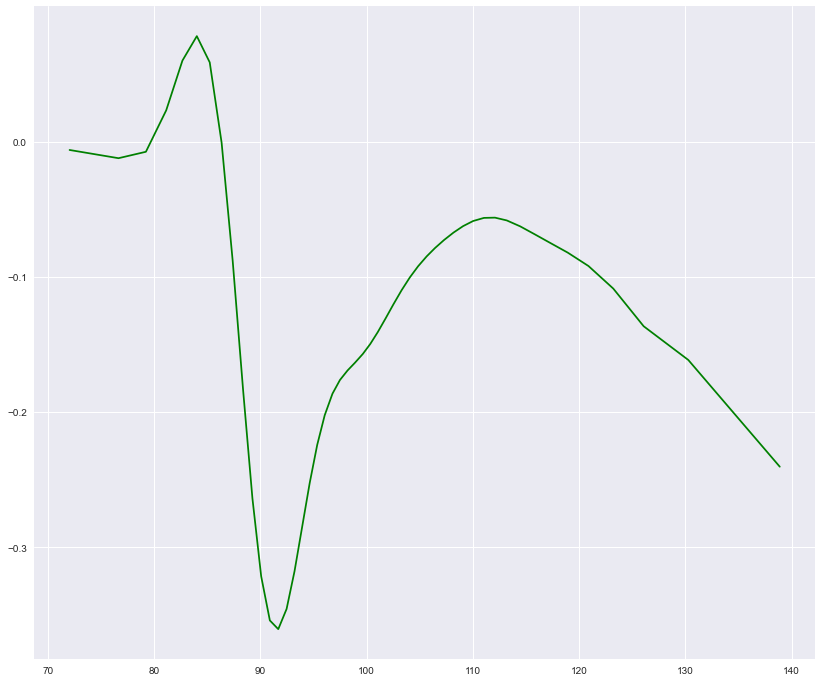

In [3032]:
plt.figure(figsize = [14, 12])
plt.plot(np.atleast_2d(sp).T, values[2], 'g', label='Residual')

In [3033]:
portList

[array([-0.65566012,  0.59078685,  3.37465794, -3.9210998 ,  1.58345231]),
 array([-0.32878185,  0.29625165,  1.98020313, -1.87751812,  0.93453657]),
 array([-0.06737211,  0.0607071 ,  0.92029991,  0.05418575,  0.04229981]),
 array([-0.03593702,  0.03238241,  0.88827039,  0.17396502, -0.05354156]),
 array([-0.0140863 ,  0.01269165,  0.95161692,  0.08693226, -0.03569026])]

In [3035]:
import time

S0 = 100.0
numPath = 100000
K = 100.0
r = 0.02
H = 90.0
sigmaP = 0.2
sigmaQ = 0.2
dts = [0.0, 0.5, 1.0]
T = dts[len(dts)-1]
grid = 200
dt = T / grid

spval = []
mse = []
abserr = []
#np.random.seed(0)

spSim = np.linspace(0.0, T, num=grid)
spSim = np.sort(np.unique(np.hstack([spSim, dts])))

(SAll_P, WAll_P) = BlackScholesExactSimulationSobol(S0, spSim, r, sigmaP, numPath)
(SAll_Q, WAll_Q) = BlackScholesExactSimulationSobol(S0, spSim, r, sigmaQ, numPath)

S_P = np.vstack([SAll_P[0], SAll_P[spSim.tolist().index(dts[1])], SAll_P[-1]])
S_Q = np.vstack([SAll_Q[0], SAll_Q[spSim.tolist().index(dts[1])], SAll_Q[-1]])

S_PT = S_P[-1]
S_QT = S_Q[-1]

bP = np.maximum(S_PT - K, 0.0) * (np.min(S_P,axis=0) > H)
bQ = np.maximum(S_QT - K, 0.0) * (np.min(S_Q,axis=0) > H)

sp = np.linspace(1.0, 99.0, num=50)
sp = np.percentile(S_P[1],sp)

payoffs_P, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_PT)
payoffs_Q, vlabels = TerminalVanillaPayoff(putStrikes, callStrikes, S_QT)

values = []

for i in range(len(portList)):
    port_tiled = np.tile(portList[i], numPath).reshape(numPath, -1).T
    port = np.sum(payoffs_P * port_tiled,0)
    res = bP - port

    payoffs = []
    payoffs.append(res)

    for p in payoffs:
        kout = []
        priceout = []
        varout = []
        covarout = []
        deltaout = []
        S2out = []
        derivout = []
        deriv2out = []

        #Silverman's rule of thumb
        payoff = p
        payoff_stdev = math.sqrt(np.var(S_PT))
        eps = 1.0 / (0.9 * payoff_stdev * numPath ** (-0.2))
        eps /= 10.0

        for start in sp:
            k = np.exp(-eps * (S[1] - start)**2)
            kout.append(np.sum(k) + 1e-7)

        kRatio = max(kout) / kout
        kRatio = np.minimum(10.0, max(kout) / kout)

        #kernel regression
        for idx, start in enumerate(sp):
            epsBS = eps
            epsBS /= kRatio[idx]
            k = np.exp(-epsBS * (S_P[1] - start)**2) + 1e-10

            #excl anything that already knocked out
            #k[np.min(SAll_P[0:np.argmin(spSim < dts[1])], axis=0) < H] = 0.0

            diff = (S_P[1] - start)
            kd = k * diff
            kd2 = kd *  diff
            wll = k * np.sum(kd2) - diff * k * np.sum(kd)
            wllsum = np.sum(wll) + 1e-10

            kout.append(np.sum(k))
            yprice = p

            #Have to discount by the future price
            S2Avg = np.sum(S_P[2] * wll) / wllsum
            S2Avg *= math.exp(-r*(dts[2] - dts[1]))
            S2out.append(S2Avg)

            fitprice = np.sum(yprice*wll) / wllsum
            if start < H:
                fitprice = 0.0
                payoffDeriv = 0.0

            priceout.append(fitprice)
            derivout.append(np.sum(payoffDeriv*wll) / wllsum)

            ycov = (payoff - fitprice) * (S_P[2] - S2Avg)
            covarout.append(np.sum(ycov*wll) / wllsum)
            y = (S_P[2] - S2Avg)**2
            varout.append(np.sum(y*wll) / wllsum)
            # fill NAs using forward fill

        beta = pd.array(np.array(covarout)/np.array(varout)).fillna(method='ffill').fillna(method='bfill')
        #beta = np.array(derivout)
        #beta = 0

        # Instantiate a Gaussian Process model, with an initial alpha of the full payoff sample std dev
        kernel = ConstantKernel(1.0, (1e-3, 1e10)) * RBF(1.5, (1e-3, 1e10))
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01, n_restarts_optimizer=5)
        gp.fit(np.atleast_2d(sp).T,  (np.array(priceout) + beta * (sp - S2out)))
        y_pred, gp_sigma = gp.predict(np.atleast_2d(sp).T, return_std=True)
        y_pred = np.array(y_pred) * math.exp(-r*(dts[2] - dts[1]))
        values.append(y_pred)


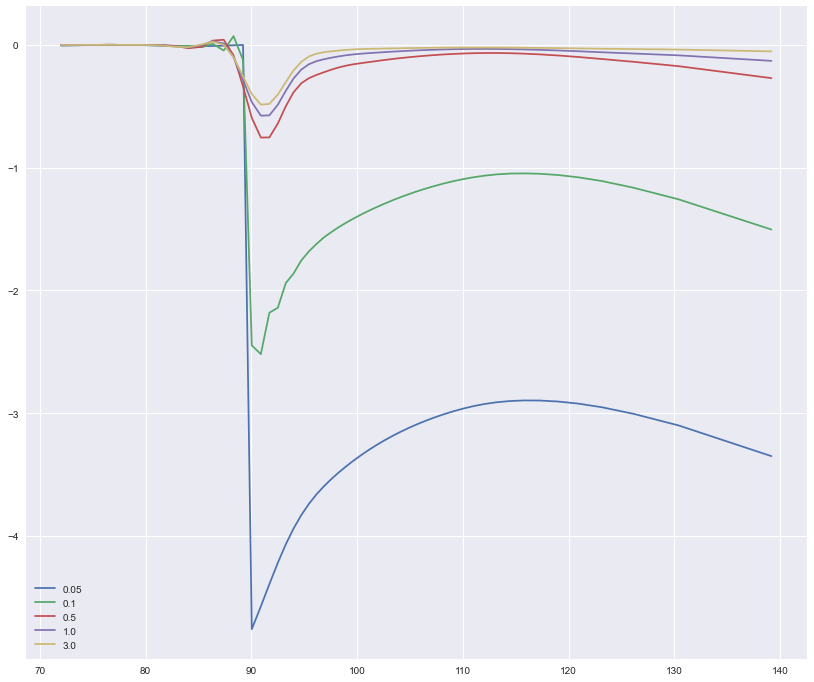

In [3036]:
plt.figure(figsize = [14, 12])
for idx in range(len(portList)):
    plt.plot(sp, values[idx], label=gammas[idx+1])

plt.legend()

In [3028]:
portList

[array([-0.65566012,  0.59078685,  3.37465794, -3.9210998 ,  1.58345231]),
 array([-0.32878185,  0.29625165,  1.98020313, -1.87751812,  0.93453657]),
 array([-0.06737211,  0.0607071 ,  0.92029991,  0.05418575,  0.04229981]),
 array([-0.03593702,  0.03238241,  0.88827039,  0.17396502, -0.05354156]),
 array([-0.0140863 ,  0.01269165,  0.95161692,  0.08693226, -0.03569026])]